<a href="https://colab.research.google.com/github/sujeet311/qsvm/blob/main/Copy_of_pQSVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
pip install qiskit_machine_learning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 126 kB 4.4 MB/s 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import BasicAer
from qiskit.circuit.library import ZZFeatureMap
#from qiskit.aqua.utils.dataset_helper import split_dataset_to_data_and_labels
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import QuantumKernel
import time

In [ ]:
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *


In [ ]:
pip install qiskit-ibmq-provider

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 240 kB 5.3 MB/s 
     |████████████████████████████████| 54 kB 1.8 MB/s 
     |████████████████████████████████| 112 kB 43.2 MB/s 
     |████████████████████████████████| 4.1 MB 40.5 MB/s 


In [ ]:
IBMQ.save_account('3e4aade17521ec826605c890d09ce72429f10032c57d8b62fb4331f7a19e3e079b8e682246e31be652f81a4f69aa2db520ef01af3f9a4bec168fda792000cb15',overwrite=True)
provider = IBMQ.load_account()

In [ ]:
from numpy import loadtxt
X_train = loadtxt('/content/drive/MyDrive/code thesis/train_test/X_train.csv',delimiter=',')
y_train = loadtxt('/content/drive/MyDrive/code thesis/train_test/y_train.csv',delimiter=',')
X_test = loadtxt('/content/drive/MyDrive/code thesis/train_test/X_test.csv',delimiter=',')
y_test = loadtxt('/content/drive/MyDrive/code thesis/train_test/y_test.csv',delimiter=',')

In [ ]:
# I scale the data to fit it to a normal distribution
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
from sklearn.decomposition import PCA

n_dim = 2
# I use PCA to reduce the number of dimensions of the dataset down to n_dim = 2
pca = PCA(n_components=n_dim).fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)


In [ ]:
 # I scale the data between -1 and 1
from sklearn.preprocessing import StandardScaler, MinMaxScaler

samples = np.append(X_train, X_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
X_train = minmax_scale.transform(X_train)
X_test = minmax_scale.transform(X_test)


In [ ]:
class_labels = ['Non-Dibetic', 'Dibetic']


In [ ]:
print(len(X_train),len(X_test))

def select_training_test_size(training_size=None, test_size=None):

    if not training_size==None:
        # I restrict the training data and test data
        training_input = {key: (X_train[y_train == k, :])[:training_size]
                          for k, key in enumerate(class_labels)}
        test_input = {key: (X_test[y_test == k, :])[:test_size]
                      for k, key in enumerate(class_labels)}

    else:
        # I keep the whole dataset
        training_input = {key: (X_train[y_train == k, :])
                          for k, key in enumerate(class_labels)}
        test_input = {key: (X_test[y_test == k, :])
                      for k, key in enumerate(class_labels)}
    return training_input, test_input

training_input, test_input = select_training_test_size()
count, count2 = 0, 0
for l in training_input.values():
    count+=len(l)
for l in test_input.values():
    count2+=len(l)
print(count, count2, count+count2)

272127 116627
272127 116627 388754


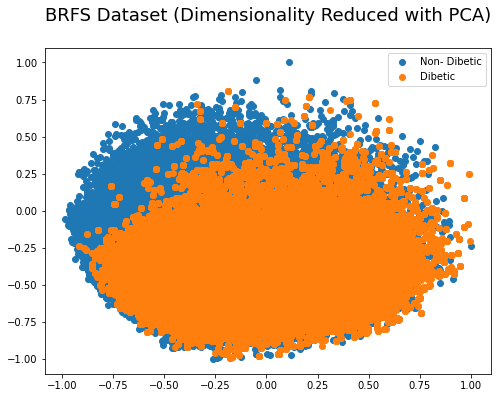

In [ ]:
# I plot the 2D representation of the data, reduced in dimensionality using PCA
plt.figure(figsize=(8, 6))
for k in range(0, 2):
    x_axis_data = X_train[y_train == k, 0][:len(X_train)]
    y_axis_data = X_train[y_train == k, 1][:len(X_train)]
    if k is 1:
        label = 'Dibetic'
    else:
        label = 'Non- Dibetic'
    plt.scatter(x_axis_data, y_axis_data, label=label)
plt.title("BRFS Dataset (Dimensionality Reduced with PCA)\n",
          fontdict = {'fontsize': 18})
plt.legend()
plt.savefig("plot2.png")
plt.show()

In [ ]:
# number of qubits is equal to the number of features
num_qubits = 2

# number of steps performed during the training procedure
tau = 100

# regularization parameter
C = 1000



In [ ]:
from qiskit import BasicAer
from qiskit.circuit.library import ZZFeatureMap
from qiskit.utils import QuantumInstance, algorithm_globals
algorithm_globals.random_seed = 12345

pegasos_backend = QuantumInstance(
    BasicAer.get_backend("statevector_simulator"),
    seed_simulator=algorithm_globals.random_seed,
    seed_transpiler=algorithm_globals.random_seed,
)

feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=2)

qkernel = QuantumKernel(feature_map=feature_map, quantum_instance=pegasos_backend)

In [ ]:
print(feature_map)

     ┌──────────────────────────┐
q_0: ┤0                         ├
     │  ZZFeatureMap(x[0],x[1]) │
q_1: ┤1                         ├
     └──────────────────────────┘


In [ ]:
from qiskit_machine_learning.algorithms import PegasosQSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

pegasos_qsvc = PegasosQSVC(quantum_kernel=qkernel, C=C, num_steps=tau)

# training
pegasos_qsvc.fit(X_train, y_train)
y_pred = pegasos_qsvc.predict(X_test)

# print(accuracy_score(y_train, pegasos_qsvc.predict(X_train)))

pegasos_qsvc = accuracy_score(y_test, y_pred)
print(pegasos_qsvc)
# confusion matrix

print(confusion_matrix(y_test, y_pred))
# classification report

print(classification_report(y_test, y_pred))

0.536308059025783
[[27103 30927]
 [23152 35445]]
              precision    recall  f1-score   support

         0.0       0.54      0.47      0.50     58030
         1.0       0.53      0.60      0.57     58597

    accuracy                           0.54    116627
   macro avg       0.54      0.54      0.53    116627
weighted avg       0.54      0.54      0.53    116627



With our training and testing datasets ready, we set up the QuantumKernel class to calculate a kernel matrix using the ZZFeatureMap, and the Aer qasm_simulator using 1024 shots

In [ ]:
from joblib import Parallel, delayed
import joblib
# Save the model as a pickle in a file
joblib.dump(pegasos_qsvc, '/content/drive/MyDrive/code thesis/ml_model/pqsvm.pkl')